# Importing Libraries

In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from difflib import SequenceMatcher
import Levenshtein
import distance
from fuzzywuzzy import fuzz
from gensim.models import Word2Vec, KeyedVectors
from sklearn.metrics.pairwise import pairwise_distances

# Text Pre-Processing

So far we have only used and dealed with features not realted to questions themslef something like frequency of question, diffrence in length, etc. But now it's time to start dealing with actual questions content, the question body or the strings and this is very important stage because the qesutins themself is what we should really focus on.

Before start designing features related to questions string we should first apply some preprocessing steps over the text we have such as removing stopwords, stemming, some kind of regular expression, etc.

we will apply text preprocssing as following:

1. remove punctioation

2. remove html tags

3. remove number

4. preforming stemming

5. remove stopwords

In [5]:
train_data = pd.read_csv("Data/train_data.csv", compression = "bz2")

test_data = pd.read_csv("Data/test_data.csv", compression = "bz2")

In [6]:
# downloading stopwords corpus
nltk.download("stopwords")
# do download stopwords using nltk.download(stopwords) first then import nltk.corpus.stopwords
stopwords = stopwords.words("english")
stopwords.remove("not")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(stopwords[:10])

print("not" in stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
False


In [7]:
stopwords = set(stopwords)

Text Pre-Process steps including:

1. removing special characters

2. removing html tags

3. removing punctiation

4. replacing shortcut with it's original words

5. use stemming based on SnowBallStemmer

In [8]:
def pre_process(question):

  question = str(question).lower()
  
  question = question.replace(",000,000", "million ").replace(",000", "thousand ").replace("won't", "will not ")
  
  question = question.replace("can't", "can not ").replace("cannot", "can not ").replace("it's", "it is ").replace("what's", "what is ")

  question = question.replace("isn't", "is not ").replace("aren't", "are not ")
  
  question = question.replace("'ve", "have ").replace("i'm", "i am ").replace("'re", "are ").replace("he's", "he is ").replace("she's", "she is ")

  question = question.replace("don't", "do not ").replace("doesn't", "does not ").replace("n't", "not ").replace("'s", " own ")

  question = question.replace("'ll", "will ").replace("%", "percent ").replace("$", " dollar ").replace("€", " euro ")

  question = re.sub(r"[0-9]+000000", r" million ", question)
  
  question = re.sub(r"[0-9]+000", r" thousand ", question)

  question = re.sub(r'[\W\s]', ' ', question)

  question = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "",   question)

  pattern = re.compile(r'<.*?>')
  question = re.sub(pattern, '', question)

  question = stemmer.stem(question)
             
  return question

In [9]:
stemmer = SnowballStemmer("english")

# Design Advanced Features

After we have done designing basic features and analysing them, We now want to design some advanced features and by advanced i mean some complex feature based on the questions text themself.

Here just to be clear we mean here by tokens all words in question and by words we mean words without stopwords.

We shall design the following **Features**:

1. **common_words_to_min_count**:  the ratio of common words count to min lenght of word count of question1 and question2

2. **common_words_to_max_count**:  the ratio of common words count to max lenght of word count of question1 and question2

3. **common_stops_to_min_count**:  the ratio of common stop words count to min lenght of word count of question1 and question2

4. **common_stops_to_max_count**:  the ratio of common stop words count to max lenght of word count of question1 and question2

5. **last_word_equal**: is the last word of question1 equal the last word of question2

6. **first_word_equal**: is the first word of question1 equal the first word of question2

7. **sequence_matcher**: sequence matcher result of question1 and question2 only on words

8. **ecludian_distances**: Ecludian distance between two questions vectors

9. **common_token_to_min_count**: the ratio of common tokens count to min length of token count of quesiton1 and quesiton2

10. **common_token_to_max_count**: the ratio of common tokens count to max length of token count of quesiton1 and quesiton2

11. **token_diff**: the absolute diffrence between length of tokens of question1 and question2

12. **lognest_substring_ratio**: ratio of length of longest common substring to min lenghth of token count of quesiton1 and question2

13. **fuzz_ratio**

14. **fuzz_partial_ratio**

15. **token_sort_ratio**

16. **token_set_ratio**

17. **Levenshtein distance**

In [10]:
def get_features(questions1, questions2):
  
  # initializing result list of list
  # each one of those lists is for one column in dataset
  feats = [[], [], [], [], [], [], [], [], []]
  
  # small number in order to avoid dividing by zero in some cases
  eps = 1e-4

  # we keep indicator [index of row] to detect corrupted rows and put them in corrupter list so:  index -----> corrupted
  index, corrupted = 0, []
  
  for question1, question2 in zip(questions1, questions2):

    f = []
    
    # pre_process question1 and question2 as mentioned earlier
    question1 = pre_process(question1)
    question2 = pre_process(question2)
    
    # tokens is the splitting result of question1 or question2 including stopwords
    question1_tokens = question1.split()
    question2_tokens = question2.split()

    # words in tokens without stopwords
    question1_words = set([word for word in question1_tokens if word not in stopwords])
    question2_words = set([word for word in question2_tokens if word not in stopwords])

    question1_stops = set([word for word in question1_tokens if word in stopwords])
    question2_stops = set([word for word in question2_tokens if word in stopwords])

    common_words_count = len(question1_words & question2_words)
    
    common_stops_count = len(question1_stops & question2_stops)
    
    common_tokens_count = len(set(question1_tokens) & set(question2_tokens))

    try:
    
      f.append(  common_words_count / (min(len(question1_words), len(question2_words)) + eps)  )
      
      f.append(  common_words_count / (max(len(question1_words), len(question2_words)) + eps)  )

      f.append(  common_stops_count / (min(len(question1_stops), len(question2_stops)) + eps)  )

      f.append(  common_stops_count / (max(len(question1_stops), len(question2_stops)) + eps)  )

      f.append(  common_tokens_count / (min(len(question1_tokens), len(question2_tokens)) + eps) )

      f.append(  common_tokens_count / (min(len(question1_tokens), len(question2_tokens)) + eps) )

      f.append(  int(question1_tokens[-1] == question2_tokens[-1]) )
      
      f.append(  int(question1_tokens[0] == question2_tokens[0]) )

      f.append(  abs(len(question1_tokens) - len(question2_tokens)))
      
      index += 1

      feats[0].append(  f[0]  )
      feats[1].append(  f[1]  )
      feats[2].append(  f[2]  )
      feats[3].append(  f[3]  )
      feats[4].append(  f[4]  )
      feats[5].append(  f[5]  )
      feats[6].append(  f[6]  )
      feats[7].append(  f[7]  )
      feats[8].append(  f[8]  )


    except:
      
      # in case of faliure we add -999999 to corrupted rows
      # if we don't do that we will end up with feats list shorted than train_data length
      for i in range(9):
        feats[i].append(-999999)
      
      # keep index of corrupted rows in corrupted list to drop those rows later
      corrupted.append(index)
      index += 1

  return feats, corrupted

We should first remove rows with only question mark on either question1 or question2 or both so that it will not generate error because while removeing punctioation marks this would leave question1 or question2 empty.

In [ ]:
print("Number of rows with only ? on question1", len(train_data[train_data.question1 == '?']))
print("Number of rows with only ? on question2", len(train_data[train_data.question2 == '?']))

Number of rows with only ? on question1 10
Number of rows with only ? on question2 1


In [ ]:
print("Length of train data before cleaning ? rows", len(train_data))

Length of train data before cleaning ? rows 323478


In [ ]:
# removing rows with question mark on question1 columns
train_data = train_data[train_data.question1 != '?']

# removing rows with question mark on question2 columns
train_data = train_data[train_data.question2 != '?']

Here we have some rows with very short question1 or question2, and those rows with label = 0
obviously those rows are not duplicated because how can be the length of quetion1 or question2 to be 3 or 4 characters and the length of the other question to be +20 character for example?

the obvious answer in this case is: lebel = 0 hence not_duplicate and this rows in not informative and meaningliess in term of advanced features which based on actual text data from question data so i choose to remove them and drop them out of the processiong.

In [ ]:
train_data[(train_data.question1.str.len() < 4) & (train_data.is_duplicate == 0)]

,id,qid1,qid2,question1,question2,is_duplicate,question1_len,question2_len,question1_freq,question2_freq,len_diff,question1_n_words,question2_n_words,words_diff,words_common,words_share,frequency_sum,frequency_diff,words_share_square,words_share_log,words_common_square
17960,86472,171723,171724,Is?,Does mother/son incest happen in India?,0,3,39,1,1,36,1,6,5,0,0.000000,2,0,0.000000,-inf,0.0
28257,3305,6608,6609,.,Why is Cornell's endowment the lowest in the I...,0,1,56,1,1,55,1,10,9,0,0.000000,2,0,0.000000,-inf,0.0
34946,245918,484291,484292,sss,What is sss?,0,3,12,1,1,9,1,3,2,0,0.000000,2,0,0.000000,-inf,0.0
44958,301627,592373,592374,…..,What do I do with this guy?,0,3,27,1,1,24,1,7,6,0,0.000000,2,0,0.000000,-inf,0.0
49695,190600,376296,376297,‘,"Time is money.Can some one explain, how it works?",0,1,49,1,1,48,1,9,8,0,0.000000,2,0,0.000000,-inf,0.0
89491,108994,216144,216145,i,What questions to ask any drdummer?,0,1,35,1,1,34,1,6,5,0,0.000000,2,0,0.000000,-inf,0.0
109464,257115,506071,506072,hi,What should I do to get my ex-girlfriend back ...,0,2,86,1,1,84,1,19,18,0,0.000000,2,0,0.000000,-inf,0.0
117979,357182,699485,699486,H,Should I forgive the cheater?,0,1,29,1,1,28,1,5,4,0,0.000000,2,0,0.000000,-inf,0.0
127965,199140,393002,393003,I,What is the connection between Donald trump an...,0,1,69,1,1,68,1,11,10,0,0.000000,2,0,0.000000,-inf,0.0
144764,151943,300557,300558,o,What is this - “This website/URL has been bloc...,0,1,132,1,1,131,1,20,19,0,0.000000,2,0,0.000000,-inf,0.0


In [ ]:
print("number of rows with less that 4 characters in question1 and is not duplicate =", \
      len(train_data[(train_data.question1.str.len() < 4) & (train_data.is_duplicate == 0)]))

number of rows with less that 4 characters in question1 and is not duplicate = 16


In [ ]:
train_data[(train_data.question2.str.len() < 4) & (train_data.is_duplicate == 0)]

,id,qid1,qid2,question1,question2,is_duplicate,question1_len,question2_len,question1_freq,question2_freq,len_diff,question1_n_words,question2_n_words,words_diff,words_common,words_share,frequency_sum,frequency_diff,words_share_square,words_share_log,words_common_square
21667,181723,358910,358911,Why does the page reload every time I try to c...,Why,0,53,3,1,1,50,11,1,10,1,0.083333,2,0,0.288675,-2.484907,1.0
76885,109025,216206,216207,How do I make a box that I can put my phone in...,Hh,0,113,2,1,1,111,25,1,24,0,0.000000,2,0,0.000000,-inf,0.0
296720,289349,568549,568550,How do I make a box that I can put my phone in...,Hh,0,113,3,1,1,110,25,2,23,0,0.000000,2,0,0.000000,-inf,0.0
302456,198943,392619,392620,What is this?,o,0,13,1,1,1,12,3,1,2,0,0.000000,2,0,0.000000,-inf,0.0


In [ ]:
print("number of rows with less that 4 characters in question2 and is not duplicate =", \
      len(train_data[(train_data.question2.str.len() < 4) & (train_data.is_duplicate == 0)]))

number of rows with less that 4 characters in question2 and is not duplicate = 4


In [ ]:
indices = (train_data[(train_data.question1.str.len() < 4) & (train_data.is_duplicate == 0)].index).tolist() + \
          (train_data[(train_data.question2.str.len() < 4) & (train_data.is_duplicate == 0)].index).tolist()

In [ ]:
print(indices)

[17960, 28257, 34946, 44958, 49695, 89491, 109464, 117979, 127965, 144764, 152608, 162107, 166501, 196260, 218114, 238265, 21667, 76885, 296720, 302456]


In [ ]:
train_data.drop(indices, axis = 0, inplace = True)

In [ ]:
print("Length of train data after cleaning previous rows", len(train_data))

Length of train data after cleaning previous rows 323447


In [11]:
features, corrupted = get_features(train_data.question1, train_data.question2)

In [12]:
print("Number of corrupted indices with either empty or ... or etc. =", len(corrupted))

Number of corrupted indices with either empty or ... or etc. = 2


We can see that question2 in both observation is empty and is not duplicate so i decide to drop those rows from our data, and similar processing and cleaning will be applied on test data as soon as we finished dealing with train data.

In [14]:
# common_words_to_min_count feature
train_data["cw_to_min_c"] = features[0]

# common_words_to_max_count feature
train_data["cw_to_max_c"] = features[1]

# common_stops_to_min_count feature
train_data["cs_to_min_c"] = features[2]

# common_stops_to_max_count feature
train_data["cs_to_max_c"] = features[3]

# common_token_to_min_count feature
train_data["ct_to_min_c"] = features[4]

# common_token_to_max_count feature
train_data["ct_to_max_c"] = features[5]

# last word equal feature
train_data["last_equal"] = features[6]

# first word equal feature
train_data["first_equal"] = features[7]

# tokens_diff feature 
train_data["tokens_diff"] = features[8]

In [15]:
train_data.loc[train_data.index[corrupted]]

,id,qid1,qid2,question1,question2,is_duplicate,question1_len,question2_len,question1_freq,question2_freq,len_diff,question1_n_words,question2_n_words,words_diff,words_common,words_share,frequency_sum,frequency_diff,words_share_square,words_share_log,words_common_square,cw_to_min_c,cw_to_max_c,cs_to_min_c,cs_to_max_c,ct_to_min_c,ct_to_max_c,last_equal,first_equal,tokens_diff,sequence_matcher,levenshtein_distance,token_set_ratio,token_sort_ratio,fuzzy_ratio,fuzzy_partial_ratio,lognest_substring_ratio,ecludian_distance
281223,20075,40057,40058,How could I solve this?,…………..,0,23,6,1,1,17,5,1,4,0,0.0,2,0,0.0,-inf,0.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999,-999999,-999999,0.0,0.0,0,0,0,0,0.0,0.0
296568,384351,751552,751553,How do I solve this?,…………..,0,20,6,1,1,14,5,1,4,0,0.0,2,0,0.0,-inf,0.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999.0,-999999,-999999,-999999,0.0,0.0,0,0,0,0,0.0,0.0


In [16]:
train_data.drop(corrupted, axis = 0, inplace = True)

In [25]:
print("Length of train data after cleaning corrupted rows", len(train_data))

Length of train data after cleaning corrupted rows 323443


Some times after some processing we would have some rows with infinite values due to dividing by very small number so we have first to check containing inf values across all columns in our data

In [ ]:
train_data[(train_data == np.inf).any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate,question1_len,question2_len,question1_freq,question2_freq,len_diff,question1_n_words,question2_n_words,words_diff,words_common,words_share,frequency_sum,frequency_diff,words_share_square,words_share_log,words_common_square,cw_to_min_c,cw_to_max_c,cs_to_min_c,cs_to_max_c,ct_to_min_c,ct_to_max_c,last_equal,first_equal,tokens_diff


So we don't have any infinite values in train data

In [26]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_len,question2_len,question1_freq,question2_freq,len_diff,question1_n_words,question2_n_words,words_diff,words_common,words_share,frequency_sum,frequency_diff,words_share_square,words_share_log,words_common_square,cw_to_min_c,cw_to_max_c,cs_to_min_c,cs_to_max_c,ct_to_min_c,ct_to_max_c,last_equal,first_equal,tokens_diff,sequence_matcher,levenshtein_distance,token_set_ratio,token_sort_ratio,fuzzy_ratio,fuzzy_partial_ratio,lognest_substring_ratio,ecludian_distance
0,84246,167321,167322,Which team will win the 2018 World Cup?,What teams will be in the 2018 World Cup?,1,39,41,1,1,2,8,9,1,5,0.294118,2,0,0.542326,-1.223775,2.236068,0.749981,0.599988,0.666644,0.399992,0.624992,0.624992,1,0,1,0.875000,0.875000,79,79,87,85,0.550000,6.915161
1,93023,184683,184684,"Which city is better to live, Dubai or Riyadh?",Is Riyadh a safe city to work?,0,46,30,1,1,16,9,7,2,3,0.187500,2,0,0.433013,-1.673976,1.732051,0.499988,0.399992,0.666644,0.499988,0.571420,0.571420,0,0,2,0.236842,0.368421,74,55,38,37,0.225806,5.968747
2,1134,2269,2270,What were Hillary Clinton's positive achieveme...,What is Hillary Clinton's greatest achievement...,1,72,71,1,1,1,10,11,1,7,0.333333,2,0,0.577350,-1.098612,2.645751,0.666656,0.666656,0.799984,0.666656,0.727266,0.727266,1,1,1,0.853147,0.853147,85,79,85,85,0.277778,10.529813
3,112175,222414,222415,Where can I find a list of companies in india ...,There are few startups in the US whose job des...,0,72,148,1,1,76,15,26,11,4,0.097561,2,0,0.312348,-2.327278,2.000000,0.571420,0.333331,0.249997,0.181817,0.399997,0.399997,0,0,12,0.354545,0.427273,62,53,45,54,0.150685,12.234524
4,277626,545847,545848,What video will show about 10 different extras...,Will the fight between the U.S. & Russia end l...,0,153,83,1,1,70,26,17,9,6,0.139535,2,0,0.373544,-1.969441,2.449490,0.428565,0.249998,0.624992,0.384612,0.470585,0.470585,0,0,11,0.406780,0.483051,66,52,51,52,0.238095,14.392029


In [ ]:
train_data["sequence_matcher"] = train_data.apply(lambda row : SequenceMatcher(a = row.question1, b = row.question2).ratio(), axis = 1)

train_data["levenshtein_distance"] = train_data.apply(lambda row : Levenshtein.ratio(row.question1, row.question2), axis = 1)

In [ ]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_len,question2_len,question1_freq,question2_freq,len_diff,question1_n_words,question2_n_words,words_diff,words_common,words_share,frequency_sum,frequency_diff,words_share_square,words_share_log,words_common_square,cw_to_min_c,cw_to_max_c,cs_to_min_c,cs_to_max_c,ct_to_min_c,ct_to_max_c,last_equal,first_equal,tokens_diff,sequence_matcher,levenshtein distance
0,84246,167321,167322,Which team will win the 2018 World Cup?,What teams will be in the 2018 World Cup?,1,39,41,1,1,2,8,9,1,5,0.294118,2,0,0.542326,-1.223775,2.236068,0.749981,0.599988,0.999967,0.999967,0.624992,0.624992,1,0,1,0.875000,0.875000
1,93023,184683,184684,"Which city is better to live, Dubai or Riyadh?",Is Riyadh a safe city to work?,0,46,30,1,1,16,9,7,2,3,0.187500,2,0,0.433013,-1.673976,1.732051,0.499988,0.399992,0.999975,0.999975,0.571420,0.571420,0,0,2,0.236842,0.368421
2,1134,2269,2270,What were Hillary Clinton's positive achieveme...,What is Hillary Clinton's greatest achievement...,1,72,71,1,1,1,10,11,1,7,0.333333,2,0,0.577350,-1.098612,2.645751,0.666656,0.666656,0.999980,0.999980,0.727266,0.727266,1,1,1,0.853147,0.853147
3,112175,222414,222415,Where can I find a list of companies in india ...,There are few startups in the US whose job des...,0,72,148,1,1,76,15,26,11,4,0.097561,2,0,0.312348,-2.327278,2.000000,0.571420,0.333331,0.999988,0.999988,0.399997,0.399997,0,0,12,0.354545,0.427273
4,277626,545847,545848,What video will show about 10 different extras...,Will the fight between the U.S. & Russia end l...,0,153,83,1,1,70,26,17,9,6,0.139535,2,0,0.373544,-1.969441,2.449490,0.428565,0.249998,0.999992,0.999992,0.470585,0.470585,0,0,11,0.406780,0.483051


In [ ]:
train_data['token_set_ratio'] = train_data.apply(lambda row : fuzz.token_set_ratio(row.question1 , row.question2) , axis = 1)

train_data['token_sort_ratio'] = train_data.apply(lambda row : fuzz.token_sort_ratio(row.question1 , row.question2) , axis = 1)

train_data['fuzzy_ratio'] = train_data.apply(lambda row : fuzz.QRatio(row.question1 , row.question2) , axis = 1)

train_data['fuzzy_partial_ratio'] = train_data.apply(lambda row : fuzz.partial_ratio(row.question1 , row.question2) , axis = 1)

In [ ]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_len,question2_len,question1_freq,question2_freq,len_diff,question1_n_words,question2_n_words,words_diff,words_common,words_share,frequency_sum,frequency_diff,words_share_square,words_share_log,words_common_square,cw_to_min_c,cw_to_max_c,cs_to_min_c,cs_to_max_c,ct_to_min_c,ct_to_max_c,last_equal,first_equal,tokens_diff,sequence_matcher,levenshtein distance,token_set_ratio,token_sort_ratio,fuzzy_ratio,fuzzy_partial_ratio
0,84246,167321,167322,Which team will win the 2018 World Cup?,What teams will be in the 2018 World Cup?,1,39,41,1,1,2,8,9,1,5,0.294118,2,0,0.542326,-1.223775,2.236068,0.749981,0.599988,0.999967,0.999967,0.624992,0.624992,1,0,1,0.875000,0.875000,79,79,87,85
1,93023,184683,184684,"Which city is better to live, Dubai or Riyadh?",Is Riyadh a safe city to work?,0,46,30,1,1,16,9,7,2,3,0.187500,2,0,0.433013,-1.673976,1.732051,0.499988,0.399992,0.999975,0.999975,0.571420,0.571420,0,0,2,0.236842,0.368421,74,55,38,37
2,1134,2269,2270,What were Hillary Clinton's positive achieveme...,What is Hillary Clinton's greatest achievement...,1,72,71,1,1,1,10,11,1,7,0.333333,2,0,0.577350,-1.098612,2.645751,0.666656,0.666656,0.999980,0.999980,0.727266,0.727266,1,1,1,0.853147,0.853147,85,79,85,85
3,112175,222414,222415,Where can I find a list of companies in india ...,There are few startups in the US whose job des...,0,72,148,1,1,76,15,26,11,4,0.097561,2,0,0.312348,-2.327278,2.000000,0.571420,0.333331,0.999988,0.999988,0.399997,0.399997,0,0,12,0.354545,0.427273,62,53,45,54
4,277626,545847,545848,What video will show about 10 different extras...,Will the fight between the U.S. & Russia end l...,0,153,83,1,1,70,26,17,9,6,0.139535,2,0,0.373544,-1.969441,2.449490,0.428565,0.249998,0.999992,0.999992,0.470585,0.470585,0,0,11,0.406780,0.483051,66,52,51,52


Now i have created the following function based of distance library in order to get longest common substring between question1 and quesiton2, the function will consider quetsion1 and question2 in term of letters not words so we call list upon the result.

In [ ]:
def logest_common_substring(question1, question2):

  lcs = list(distance.lcsubstrings(question1, question2))
  
  if len(lcs) == 0:
    return 0
  
  # +1 so we don't fail into dividing by zero problem
  # lcs[0] is the string itself as the result is list of string example: ["result"]
  return len(lcs[0]) / ( min(len(question1), len(question2)) + 1)

In [ ]:
train_data["lognest_substring_ratio"] = train_data.apply(lambda row: logest_common_substring(row.question1, row.question2), axis = 1)

In [ ]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_len,question2_len,question1_freq,question2_freq,len_diff,question1_n_words,question2_n_words,words_diff,words_common,words_share,frequency_sum,frequency_diff,words_share_square,words_share_log,words_common_square,cw_to_min_c,cw_to_max_c,cs_to_min_c,cs_to_max_c,ct_to_min_c,ct_to_max_c,last_equal,first_equal,tokens_diff,sequence_matcher,levenshtein distance,token_set_ratio,token_sort_ratio,fuzzy_ratio,fuzzy_partial_ratio,lognest_substring_ratio
0,84246,167321,167322,Which team will win the 2018 World Cup?,What teams will be in the 2018 World Cup?,1,39,41,1,1,2,8,9,1,5,0.294118,2,0,0.542326,-1.223775,2.236068,0.749981,0.599988,0.999967,0.999967,0.624992,0.624992,1,0,1,0.875000,0.875000,79,79,87,85,0.550000
1,93023,184683,184684,"Which city is better to live, Dubai or Riyadh?",Is Riyadh a safe city to work?,0,46,30,1,1,16,9,7,2,3,0.187500,2,0,0.433013,-1.673976,1.732051,0.499988,0.399992,0.999975,0.999975,0.571420,0.571420,0,0,2,0.236842,0.368421,74,55,38,37,0.225806
2,1134,2269,2270,What were Hillary Clinton's positive achieveme...,What is Hillary Clinton's greatest achievement...,1,72,71,1,1,1,10,11,1,7,0.333333,2,0,0.577350,-1.098612,2.645751,0.666656,0.666656,0.999980,0.999980,0.727266,0.727266,1,1,1,0.853147,0.853147,85,79,85,85,0.277778
3,112175,222414,222415,Where can I find a list of companies in india ...,There are few startups in the US whose job des...,0,72,148,1,1,76,15,26,11,4,0.097561,2,0,0.312348,-2.327278,2.000000,0.571420,0.333331,0.999988,0.999988,0.399997,0.399997,0,0,12,0.354545,0.427273,62,53,45,54,0.150685
4,277626,545847,545848,What video will show about 10 different extras...,Will the fight between the U.S. & Russia end l...,0,153,83,1,1,70,26,17,9,6,0.139535,2,0,0.373544,-1.969441,2.449490,0.428565,0.249998,0.999992,0.999992,0.470585,0.470585,0,0,11,0.406780,0.483051,66,52,51,52,0.238095


Now it's time to convert the actual text values from quetstion1 and question2 by converting them into numeric vectors in order to compare them and get distance between them, for this task i choose to use Average Word2Vec using google news pre trained model rather than training new model in our corpus.

In [ ]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary = True)

--2021-10-03 04:38:02--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.0.141
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.0.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  97.2MB/s    in 20s     

2021-10-03 04:38:22 (78.7 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
vocab = word2vec.vocab
print("Number of words in vocabulary =", len(vocab))

Number of words in vocabulary = 3000000


In [ ]:
def apply_word2vec(quesiton1, quesiton2):

  # prepare question1 & question2 numeric vector
  question1_vector = np.zeros(300, dtype = np.float32)
  question2_vector = np.zeros(300, dtype = np.float32)

  # q1_words to count number of words in question1 in vocab
  # q2_words to count number of words in question2 in vocab
  q1_words, q2_words = 0, 0

  # for each word in question and in vocab add word2vec vector result into feature vector and increase counter by 1
  for word1, word2 in zip(pre_process(question1).split(), pre_process(question2).split() ):

    if word1 in vocab:

      q1_words += 1
      question1_vector = np.add(question1_vector, word2vec[word1])

    if word2 in vocab:

      q2_words += 1
      question2_vector = np.add(question2_vector, word2vec[word2])

  if q1_words > 0:
    quesiton1_vector = np.divide(question1_vector, q1_words)
    
  if q2_words > 0:
    question2_vector = np.divide(question2_vector, q2_words)

  return question1_vector, question2_vector

In [ ]:
question1_vectors, question2_vectors = [], []

for question1, question2 in zip(train_data.question1.values, train_data.question2.values):

  v1, v2 = apply_word2vec(  question1, question2  )

  question1_vectors.append(v1)
  question2_vectors.append(v2)

In [ ]:
question1_vectors = np.array(question1_vectors)

question2_vectors = np.array(question2_vectors)

In [ ]:
ecludian_distance = []

for vec1, vec2 in zip(question1_vectors, question2_vectors):
  ecludian_distance.append( pairwise_distances(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0] )

train_data["ecludian_distance"] = ecludian_distance

In [ ]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_len,question2_len,question1_freq,question2_freq,len_diff,question1_n_words,question2_n_words,words_diff,words_common,words_share,frequency_sum,frequency_diff,words_share_square,words_share_log,words_common_square,cw_to_min_c,cw_to_max_c,cs_to_min_c,cs_to_max_c,ct_to_min_c,ct_to_max_c,last_equal,first_equal,tokens_diff,sequence_matcher,levenshtein_distance,token_set_ratio,token_sort_ratio,fuzzy_ratio,fuzzy_partial_ratio,lognest_substring_ratio,ecludian_distance
0,84246,167321,167322,Which team will win the 2018 World Cup?,What teams will be in the 2018 World Cup?,1,39,41,1,1,2,8,9,1,5,0.294118,2,0,0.542326,-1.223775,2.236068,0.749981,0.599988,0.999967,0.999967,0.624992,0.624992,1,0,1,0.875000,0.875000,79,79,87,85,0.550000,6.915161
1,93023,184683,184684,"Which city is better to live, Dubai or Riyadh?",Is Riyadh a safe city to work?,0,46,30,1,1,16,9,7,2,3,0.187500,2,0,0.433013,-1.673976,1.732051,0.499988,0.399992,0.999975,0.999975,0.571420,0.571420,0,0,2,0.236842,0.368421,74,55,38,37,0.225806,5.968747
2,1134,2269,2270,What were Hillary Clinton's positive achieveme...,What is Hillary Clinton's greatest achievement...,1,72,71,1,1,1,10,11,1,7,0.333333,2,0,0.577350,-1.098612,2.645751,0.666656,0.666656,0.999980,0.999980,0.727266,0.727266,1,1,1,0.853147,0.853147,85,79,85,85,0.277778,10.529813
3,112175,222414,222415,Where can I find a list of companies in india ...,There are few startups in the US whose job des...,0,72,148,1,1,76,15,26,11,4,0.097561,2,0,0.312348,-2.327278,2.000000,0.571420,0.333331,0.999988,0.999988,0.399997,0.399997,0,0,12,0.354545,0.427273,62,53,45,54,0.150685,12.234524
4,277626,545847,545848,What video will show about 10 different extras...,Will the fight between the U.S. & Russia end l...,0,153,83,1,1,70,26,17,9,6,0.139535,2,0,0.373544,-1.969441,2.449490,0.428565,0.249998,0.999992,0.999992,0.470585,0.470585,0,0,11,0.406780,0.483051,66,52,51,52,0.238095,14.392029


Now we shall apply the same steps we have done on training data on test data, we certainly could put the code in one function and then calling this fucntion two times one for training data and one for testing data but i intend to do that just for calrification.

In [27]:
test_data = test_data[test_data.question1 != '?']

test_data = test_data[test_data.question2 != '?']

indices = (train_data[(train_data.question1.str.len() < 4) & (train_data.is_duplicate == 0)].index).tolist() + \
          (train_data[(train_data.question2.str.len() < 4) & (train_data.is_duplicate == 0)].index).tolist()

test_data.drop(indices, axis = 0, inplace = True)

features, corrupted = get_features(test_data.question1, test_data.question2)

In [28]:
test_data["cw_to_min_c"] = features[0]

test_data["cw_to_max_c"] = features[1]

test_data["cs_to_min_c"] = features[2]

test_data["cs_to_max_c"] = features[3]

test_data["ct_to_min_c"] = features[4]

test_data["ct_to_max_c"] = features[5]

test_data["last_equal"] = features[6]

test_data["first_equal"] = features[7]

test_data["tokens_diff"] = features[8]

In [30]:
test_data.loc[corrupted]

,id,qid1,qid2,question1,question2,is_duplicate,question1_len,question2_len,question1_n_words,question2_n_words,question1_freq,question2_freq,len_diff,words_diff,words_common,words_share,frequency_sum,frequency_diff,words_share_square,words_share_log,words_common_square,cw_to_min_c,cw_to_max_c,cs_to_min_c,cs_to_max_c,ct_to_min_c,ct_to_max_c,last_equal,first_equal,tokens_diff,sequence_matcher,levenshtein_distance,token_set_ratio,token_sort_ratio,fuzzy_ratio,fuzzy_partial_ratio,lognest_substring_ratio,ecludian_distance


In [ ]:
test_data.drop(corrupted, axis = 0, inplace = True)

In [ ]:
test_data["sequence_matcher"] = test_data.apply(lambda row : SequenceMatcher(a = row.question1, b = row.question2).ratio(), axis = 1)

test_data["levenshtein_distance"] = test_data.apply(lambda row : Levenshtein.ratio(row.question1, row.question2), axis = 1)

In [ ]:
test_data['token_set_ratio'] = test_data.apply(lambda row : fuzz.token_set_ratio(row.question1 , row.question2) , axis = 1)

test_data['token_sort_ratio'] = test_data.apply(lambda row : fuzz.token_sort_ratio(row.question1 , row.question2) , axis = 1)

test_data['fuzzy_ratio'] = test_data.apply(lambda row : fuzz.QRatio(row.question1 , row.question2) , axis = 1)

test_data['fuzzy_partial_ratio'] = test_data.apply(lambda row : fuzz.partial_ratio(row.question1 , row.question2) , axis = 1)

test_data["lognest_substring_ratio"] = test_data.apply(lambda row: logest_common_substring(row.question1, row.question2), axis = 1)

In [ ]:
question1_vectors, question2_vectors = [], []

for question1, question2 in zip(test_data.question1.values, test_data.question2.values):

  v1, v2 = apply_word2vec(  question1, question2  )

  question1_vectors.append(v1)
  question2_vectors.append(v2)

In [ ]:
ecludian_distance = []

for vec1, vec2 in zip(question1_vectors, question2_vectors):
  ecludian_distance.append( pairwise_distances(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0] )

test_data["ecludian_distance"] = ecludian_distance

Now let's try to plot the features we have and the features we have created till now as a WordCloud.

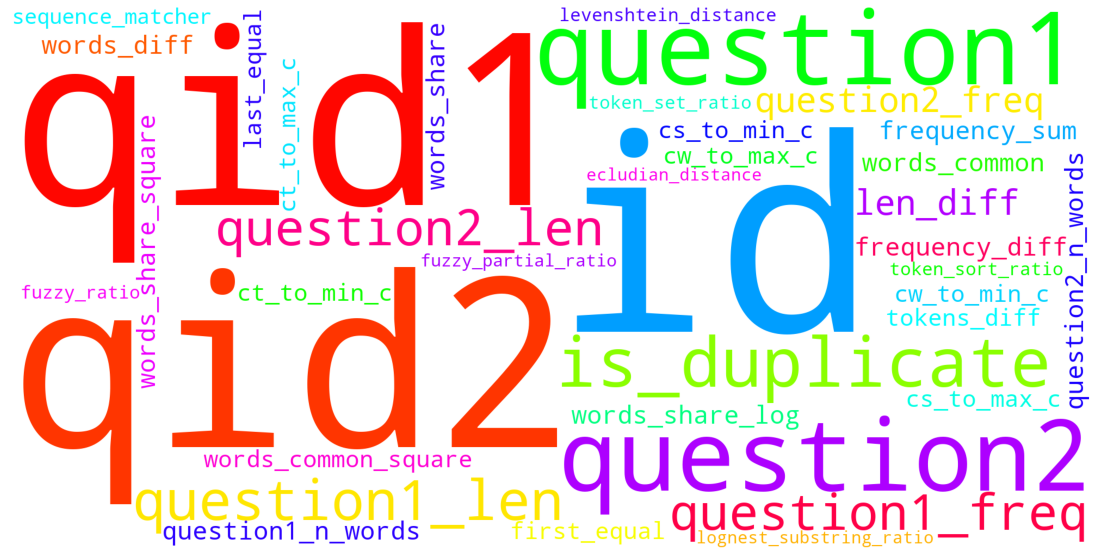

In [ ]:
feats = " ".join(train_data.columns)
word_cloud = WordCloud(height = 1000, width = 2000, background_color = "white", colormap = "hsv").generate(feats)
plt.figure(figsize = (30, 10))

plt.imshow(word_cloud)

plt.axis("off")
plt.show()

In [31]:
train_data.to_csv("/content/Data/train_data.csv", index = False, compression = "bz2")

test_data.to_csv("/content/Data/test_data.csv", index = False, compression = "bz2")